In [496]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from IPython.display import clear_output

In [497]:
df = pd.read_csv('../data/train.csv', header=0)
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [498]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

In [499]:
# Drop the ID and last column (Cover Type)
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [500]:
# Store the cover type in labels
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120,)

In [501]:
for column in data.columns:
    print(data[column].describe(), "\n")

count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64 

count    15120.000000
mean       156.676653
std        110.085801
min          0.000000
25%         65.000000
50%        126.000000
75%        261.000000
max        360.000000
Name: Aspect, dtype: float64 

count    15120.000000
mean        16.501587
std          8.453927
min          0.000000
25%         10.000000
50%         15.000000
75%         22.000000
max         52.000000
Name: Slope, dtype: float64 

count    15120.000000
mean       227.195701
std        210.075296
min          0.000000
25%         67.000000
50%        180.000000
75%        330.000000
max       1343.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64 

count    15120.000000
mean        51.076521
std         61.239406
min       -146.000000
25%          5.000000
50%         32.000000
75%         

In [502]:
# remove columns with no variance
for column in data.columns:
    if data[column].std() == 0:
        print('Drop column: {}'.format(column))
        data.drop([column], axis=1, inplace=True)

print(data.shape)

Drop column: Soil_Type7
Drop column: Soil_Type15
(15120, 52)


In [503]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.33, random_state=42)

In [504]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

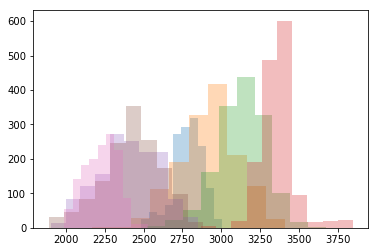

In [505]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for label in labels.unique():
    plt.hist(X_train.Elevation[y_train==label], **kwargs)

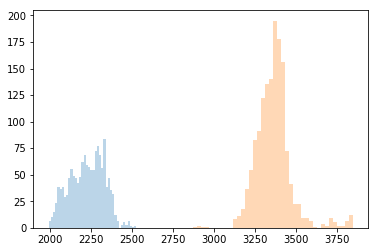

In [464]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

plt.hist(X_train.Elevation[y_train==4], **kwargs)
plt.hist(X_train.Elevation[y_train==7], **kwargs);

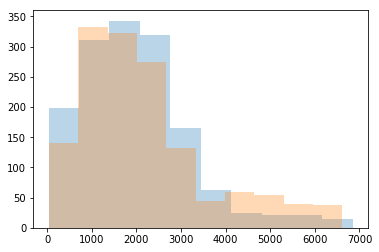

In [546]:
plt.hist(X_train.Horizontal_Distance_To_Fire_Points[y_train==1], **kwargs)
plt.hist(X_train.Horizontal_Distance_To_Fire_Points[y_train==2], **kwargs);

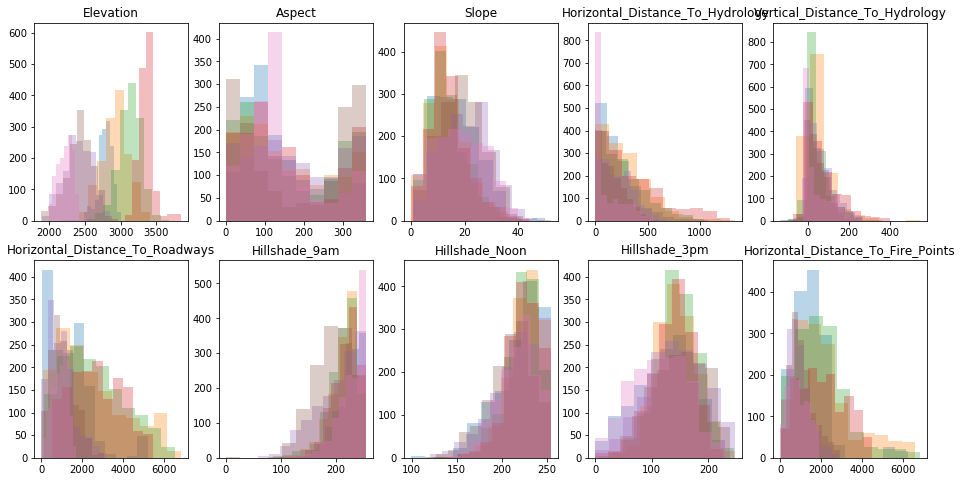

In [466]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in labels.unique():
        axi.hist(X_train.ix[y_train==label, i], **kwargs)
    axi.set_title(X_train.columns[i])

### PCA

In [69]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

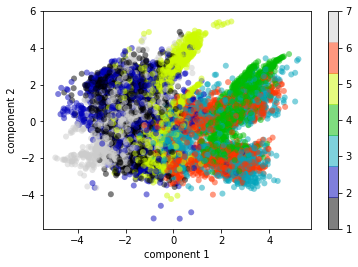

In [70]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

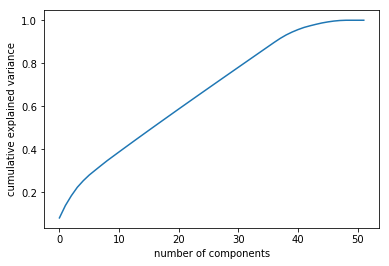

In [72]:
pca = PCA(n_components=52)
pca.fit(X_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## SVM

In [73]:
model = make_pipeline(SVC())

param_grid = {
    'svc__kernel': ['linear', 'rbf'],  # 'linear', 'rbf'
    'svc__C': [50, 100, 200],  # 1, 5, 10, 50, 100, 200
    'svc__gamma': [.01, .05, .1]}  # 0.0001, 0.0005, 0.001, 0.005, .01, .1
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
%time grid.fit(X_train_std, y_train)

CPU times: user 4.13 s, sys: 158 ms, total: 4.29 s
Wall time: 4min 5s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svc__kernel': ['linear', 'rbf'], 'svc__gamma': [0.01, 0.05, 0.1], 'svc__C': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [74]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)

{'svc__C': 100, 'svc__gamma': 0.05, 'svc__kernel': 'rbf'}


In [75]:
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.73      0.72      0.73       679
   2 - Lodgepole Pine       0.72      0.65      0.68       722
   3 - Ponderosa Pine       0.80      0.75      0.77       704
4 - Cottonwood/Willow       0.91      0.96      0.93       739
            5 - Aspen       0.88      0.91      0.89       721
      6 - Douglas-fir       0.80      0.83      0.82       722
        7 - Krummholz       0.93      0.97      0.95       703

          avg / total       0.83      0.83      0.83      4990



## Logistic Regression

In [156]:
model = make_pipeline(PCA(), PolynomialFeatures(), LogisticRegression())
c_vals = [1, 2, 4, 10] #[.0001, 0.001, 0.01, 0.1, 1, 2, 4, 10, 20, 50, 100]
tol = [.01]
param_grid = {
    'pca__n_components': range(21, 23),
    'polynomialfeatures__degree': range(1, 3),
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': ['l2', 'l1']
}
grid = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=6)
%time grid.fit(X_train_std, y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

CPU times: user 30.1 s, sys: 504 ms, total: 30.6 s
Wall time: 15min 32s
Best params for Logistic Regression: {'logisticregression__penalty': 'l2', 'polynomialfeatures__degree': 2, 'logisticregression__tol': 0.01, 'logisticregression__C': 10, 'pca__n_components': 22}


In [157]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)

{'logisticregression__penalty': 'l2', 'polynomialfeatures__degree': 2, 'logisticregression__tol': 0.01, 'logisticregression__C': 10, 'pca__n_components': 22}


In [158]:
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.66      0.65      0.65       679
   2 - Lodgepole Pine       0.67      0.57      0.61       722
   3 - Ponderosa Pine       0.70      0.68      0.69       704
4 - Cottonwood/Willow       0.83      0.95      0.88       739
            5 - Aspen       0.80      0.86      0.82       721
      6 - Douglas-fir       0.74      0.72      0.73       722
        7 - Krummholz       0.91      0.90      0.90       703

          avg / total       0.76      0.76      0.76      4990



## GMM

In [109]:
def run_exp(pca_n, gmm_n, cov_type):

    pca = PCA(n_components=pca_n)
    pca.fit(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    
    all_scores = np.zeros(y_test.shape)
    for label in range(1, len(target_names) + 1):
        X = X_train_pca[np.where(y_train == label)]
        gmm = GaussianMixture(n_components=gmm_n,
                              covariance_type=cov_type)
        gmm.fit(X)
        scores = gmm.score_samples(X_test_pca)
        all_scores = np.column_stack((all_scores, scores))
        
    all_scores = np.delete(all_scores, (0), axis=1)
    
    # choose the max index for each row for pred
    y_pred = all_scores.argmax(axis=1)
    y_pred = y_pred + 1
    accuracy = np.mean(y_pred == y_test)
    return accuracy

matrix_types = ('spherical', 'diag', 'tied', 'full')
n_pca_components = range(1, 55)
n_gmm_components = range(1, 55)
accuracies = []

for cov_type in matrix_types:
    for pca_n in n_pca_components:
        for gmm_n in n_gmm_components:
            accuracy = run_exp(pca_n=pca_n, 
                               gmm_n=gmm_n,
                               cov_type=cov_type)
            accuracies.append({'accuracy': accuracy, 'cov_type': cov_type,
                               'pca_n': pca_n, 'gmm_n': gmm_n})
            clear_output()
            print(len(accuracies))

print(sorted(accuracies, key=lambda k: k['accuracy'])[-1])

11664
{'pca_n': 9, 'cov_type': 'full', 'gmm_n': 42, 'accuracy': 0.80781563126252509}


## Forest Methods

In [79]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(X_train_std, y_train)

print ('Accuracy (a decision tree):', dt.score(X_test_std, y_test))

Accuracy (a decision tree): 0.781563126253


In [554]:
model = make_pipeline(RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 500, 1000, 5000], 
    'randomforestclassifier__criterion': ['entropy', 'gini'],
    'randomforestclassifier__max_features': [None, 'sqrt', .5, .75],
    'randomforestclassifier__max_depth': [None, 20, 30],
    'randomforestclassifier__bootstrap': [True, False],
}
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=6, verbose=1)
%time grid.fit(X_train_std, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 32.7min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 78.6min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed: 147.7min finished


CPU times: user 35.9 s, sys: 3.38 s, total: 39.3 s
Wall time: 2h 28min 10s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=6,
       param_grid={'randomforestclassifier__criterion': ['entropy', 'gini'], 'randomforestclassifier__max_depth': [None, 20, 30], 'randomforestclassifier__bootstrap': [True, False], 'randomforestclassifier__n_estimators': [100, 200, 500, 1000, 5000], 'randomforestclassifier__max_features': [None, 'sqrt', 0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [555]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)
print(classification_report(y_test, y_pred, target_names=target_names))

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__bootstrap': False, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__max_features': 'sqrt'}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.78      0.78      0.78       679
   2 - Lodgepole Pine       0.80      0.69      0.74       722
   3 - Ponderosa Pine       0.84      0.82      0.83       704
4 - Cottonwood/Willow       0.93      0.98      0.95       739
            5 - Aspen       0.90      0.95      0.92       721
      6 - Douglas-fir       0.86      0.88      0.87       722
        7 - Krummholz       0.95      0.97      0.96       703

          avg / total       0.87      0.87      0.87      4990



In [82]:
abc = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0), 
    n_estimators=200, learning_rate=0.1)

abc.fit(X_train_std, y_train)
print ('Accuracy (adaboost with decision trees):', abc.score(X_test_std, y_test))

Accuracy (adaboost with decision trees): 0.77875751503


In [467]:
def run_rand_forest(X_train, y_train, X_test, y_test): 
    rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features='sqrt', n_jobs=-1)
    rfc.fit(X_train, y_train)
    accuracy = rfc.score(X_test, y_test)
    return accuracy

def run_ridge(X_train, y_train, X_test, y_test, alpha=.1):
    ridge = RidgeClassifier(alpha=alpha, normalize=True)
    ridge.fit(X_train, y_train)
    return ridge.score(X_test, y_test)

In [468]:
run_rand_forest(X_train, y_train, X_test, y_test)

0.85490981963927859

In [469]:
run_rand_forest(X_train_std, y_train, X_test_std, y_test)

0.85951903807615226

## Feature Engineering

In [530]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.33, random_state=40)
    return X_train, y_train, X_test, y_test

In [531]:
run_rand_forest(X_train.as_matrix()[:, 0:10], y_train, X_test.as_matrix()[:, 0:10], y_test)

0.82825651302605208

In [472]:
run_ridge(X_train, y_train, X_test, y_test, )

0.62645290581162327

In [264]:
run_rand_forest(X_train.as_matrix()[:, 11:15], y_train, X_test.as_matrix()[:, 11:15], y_test)

0.32845691382765529

In [364]:
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='sqrt', n_jobs=-1)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
np.mean(preds == y_test)

0.85771543086172342

In [365]:
# msk = (y_test == 1) & (preds != 1)
# X_test.ix[msk]

### Binning hillshade_noon

In [366]:
noon_bins = np.linspace(0, 255, 4)
which_bin = np.digitize(X_train.Hillshade_Noon, bins=noon_bins)

encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin.reshape(-1, 1))
X_train_noon_binned = encoder.transform(which_bin.reshape(-1, 1))

In [367]:
X_train_with_binned = np.hstack([X_train.drop('Hillshade_Noon', axis=1), X_train_noon_binned])

which_bin = np.digitize(X_test.Hillshade_Noon, bins=noon_bins)
X_test_noon_binned = encoder.transform(which_bin.reshape(-1, 1))
X_test_with_binned = np.hstack([X_test.drop('Hillshade_Noon', axis=1), X_test_noon_binned])

In [368]:
run_rand_forest(X_train_with_binned, y_train, X_test_with_binned, y_test)

0.85671342685370744

### Convert aspect to cardinal direction (north, south, east, west)

In [509]:

new_data = data.copy(deep=True)
dir_labels = ['north east', 'east north', 'east south', 'south east', 
          'south west', 'west south', 'west north', 'north west']
new_data.loc[:, ('direction')] = pd.cut(data.loc[:, ('Aspect')], range(0, 365, 45), right=False, labels=dir_labels)

new_data.direction = new_data.direction.replace('east north', 'north') \
    .replace('north west', 'north') \
    .replace('east north', 'east').replace('east south', 'east').replace('south east', 'south') \
    .replace('south west', 'south').replace('west south', 'west').replace('west north', 'west') \
    .replace('north east', 'north')

In [510]:
new_data = pd.get_dummies(new_data)
new_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,direction_east,direction_north,direction_south,direction_west
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,1,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,1,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,1,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,1,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,1,0,0


In [533]:
run_rand_forest(*split_data(new_data, labels))

0.85350701402805607

In [536]:
run_ridge(*split_data(new_data, labels))

0.62505010020040075

### Convert horizontal and vertical distance to hydrology to euclidean distance

In [538]:
new_data = data.copy(deep=True)

new_data.loc[:, ('euclid_to_hydro')] = np.sqrt(new_data.Horizontal_Distance_To_Hydrology ** 2 \
                                               + new_data.Vertical_Distance_To_Hydrology ** 2)
new_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,euclid_to_hydro
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,258.000000
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,212.084889
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,275.769832
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,269.235956
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,153.003268


In [540]:
run_rand_forest(*split_data(new_data, labels))

0.85811623246492985

In [541]:
run_ridge(*split_data(new_data, labels))

0.62284569138276558